# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

## Filtering

The scene images contain some noise. We therfore start by denoising the scene iamges before further processing.

As the first two scene images are less noisy than the rest, we have decided to filter more for the three last images than for the two first.



In [4]:
import cv2
import numpy as np
imgs_train = ['dataset/scenes/scene{}.png'.format(i) for i in range(1, 6)]
for i in range (len(imgs_train)):
  img = cv2.imread(imgs_train[i])
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  if i < 2:
    img_rgb = cv2.bilateralFilter(img_rgb, 15, 200, 100)

  else:
    # Apply Median Blur to remove salt-and-pepper noise
    median_blur = cv2.medianBlur(img_rgb, 5)

    # Apply Gaussian Blur to smooth the image
    gaussian_blur = cv2.GaussianBlur(median_blur, (5, 5), 0)

    # Apply Bilateral Filter to preserve edges while reducing noise
    img_rgb = cv2.bilateralFilter(gaussian_blur, 9, 75, 75)

    #Edge detection
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    img_rgb = cv2.filter2D(img_rgb, -1, kernel)
    #Sharpening
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    img_rgb = cv2.filter2D(img_rgb, -1, kernel)

  name = imgs_train[i].replace(".png", "_filtered.png")
  cv2.imwrite(name, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
  print(f"save succeded as: {name}")

save succeded as: dataset/scenes/scene1_filtered.png
save succeded as: dataset/scenes/scene2_filtered.png
save succeded as: dataset/scenes/scene3_filtered.png
save succeded as: dataset/scenes/scene4_filtered.png
save succeded as: dataset/scenes/scene5_filtered.png


# Object detection with local Invariant features

We will implement object detection with local invariant features utilizing the Python framework cv2.

This wil be done in four steps:
1. Detection by finding keypoints in model an scene images.
2. Description: create description for each point.
3. Matching: match point in scene and query image based on descriptor
4. Position estimation: estimate poition of query image in scene image.

We therfore create a function *object retrive mult* and *object retrive*, which finds keypoints (step 1), descirbes them (step 2) and matches them (step 3).

We have decided to utilize SIFT due to its due to its robustness to scale, rotation, and illumination changes. The choice of SIFT is also the reason for choosing 0.7 as treshold when filtering out bad matches, as this was outlined in the paper introducing SIFT.

Furthermore we have utilized a FLANN based matcherk, which means fast nearest neighbor search.

The difference between the two funcitons is that *object retrive* is used for matching with a single instance of query image, while *object_retrieve_mult* is used when there are multiple instances of the query image. In this funciton the keypoints in the scene image are clusterd, and in this way we are assuming that keypoints close in distance belong to the same object. Step 2 and step 3 is then run for each cluster. Clustering is done using a Meanshift filter.

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Define a function for object detection pipeline
def object_retrieve(img_query, img_train_denoized, min_match_count):

    # Keypoint detection
    sift = cv2.xfeatures2d.SIFT_create()
    kp_query =  sift.detect(img_query)
    kp_train =  sift.detect(img_train_denoized)

    # Keypoint description
    kp_query, des_query =  sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train_denoized, kp_train)

    # Define parameters for the approximate nearest neighbor algorithm
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    # Initialize the Flann-based matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query,des_train,k=2)
    good = []

    # Filtering false matches using Lowe's ratio test (0.7 because SIFT)
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)> min_match_count:
      return (kp_train, good), kp_query
    else:
      return None, kp_query

In [23]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

# Define a function for object detection pipeline
def object_retrieve_mult(img_query, img_train_denoized, min_match_count):
    # Keypoint detection using SIFT
    sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=0.04)
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train_denoized)

    # Keypoint description
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train_denoized, kp_train)

    # Create array from keypoints for clustering
    x = np.array([kp.pt for kp in kp_train])  # Extract coordinates of keypoints

    # Estimate bandwidth for MeanShift clustering
    bandwidth = estimate_bandwidth(x, quantile=0.1, n_samples=500)

    # Perform MeanShift clustering
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
    ms.fit(x)  # Fit MeanShift model to the keypoint coordinates
    labels = ms.labels_  # Get cluster labels for each keypoint
    cluster_centers = ms.cluster_centers_  # Get coordinates of cluster centers

    # Determine the number of unique clusters
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    # Sort clusters by their center coordinates for consistency
    sorted_indices = np.argsort(cluster_centers[:, 0])
    sorted_labels = np.array([np.where(sorted_indices == i)[0][0] for i in labels])
    sorted_cluster_centers = cluster_centers[sorted_indices]

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Initialize FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    objects = []

    # Process each cluster
    for i in range(n_clusters_):
        cluster_indices = np.where(sorted_labels == i)[0]
        cluster_des_train = des_train[cluster_indices, :]
        matches = flann.knnMatch(des_query, cluster_des_train, k=2)

        good = []
        # Filtering false matches using Lowe's ratio test (0.7 because SIFT)
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        # If enough good matches are found, add to objects list
        if len(good) > min_match_count:
            objects.append((i, good))

    # Visualize matches
    matches = []
    for cluster_id, good_matches in objects:
        cluster_indices = np.where(sorted_labels == cluster_id)[0]
        kp_cluster = [kp_train[idx] for idx in cluster_indices]
        matches.append((kp_cluster, good_matches))

    return matches, kp_query, kp_train


We then want to do position estimation, in order to find the query_image in the scene_image. In order to get a good bounding box, even when some matches are wrong we use the RANSAC algorithm. It is an iterative method, to fit parametric model to noisy data. This is used to fin the Homogrophy in computer vision.

In [13]:
def poistion_estimation(good,kp_query, img_query, img_train_denoized):
  instances = []
  src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good[1] ]).reshape(-1,1,2)
  dst_pts =  np.float32([ good[0][m.trainIdx].pt for m in good[1] ]).reshape(-1,1,2)

  # Find Homography matrix using RANSAC
  M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

  # Mask of discarded point used in visualization
  matchesMask = mask.ravel().tolist()
  # Get the bounding box corners of the query image
  h,w = img_query.shape
  pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

  # Project the query corners onto the train image using the homography matrix
  train_corners = cv2.perspectiveTransform(pts,M)

  # Draw the bounding box
  img_train_with_box = cv2.polylines(img_train, [np.int32(train_corners)], True, (0, 255, 0), 3, cv2.LINE_AA)

  bounding_box_height = abs(train_corners[0][0][1] - train_corners[2][0][1])
  bounding_box_width = abs(train_corners[0][0][0] - train_corners[2][0][0])
  center_position = ((train_corners[0][0][0] + train_corners[2][0][0]) / 2, (train_corners[0][0][1] + train_corners[2][0][1]) / 2)

  return img_train_with_box, bounding_box_height, bounding_box_width, center_position

# Single instance

We iterate over all scene images and models with single instance, and call the two functions above in order to detect the objects.

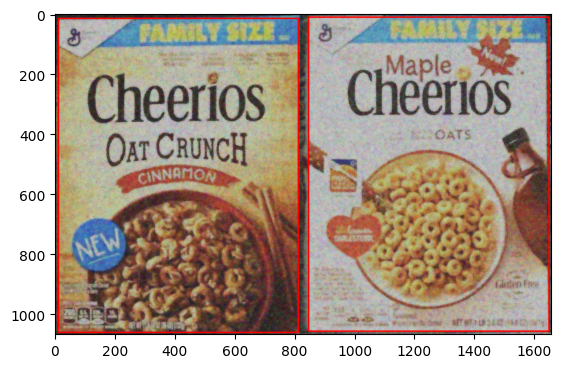

Object 1: {position: (411.9361877441406, 538.7971801757812), width: 802px, height: 1048px
Object 2: {position: (1248.24853515625, 534.3016967773438), width: 803px, height: 1048px


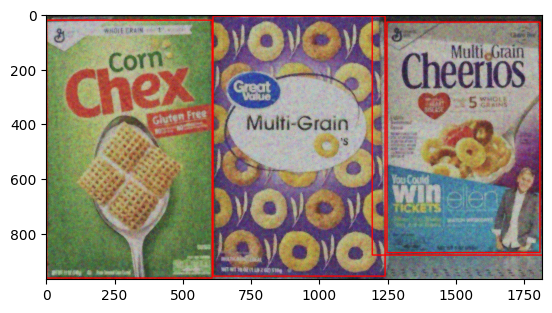

Object 2: {position: (1532.9144287109375, 438.0436096191406), width: 677px, height: 886px
Object 3: {position: (305.4559631347656, 493.4769287109375), width: 605px, height: 942px
Object 4: {position: (926.64013671875, 482.8466796875), width: 630px, height: 950px
Object 5: {position: (1528.38037109375, 450.50244140625), width: 561px, height: 843px


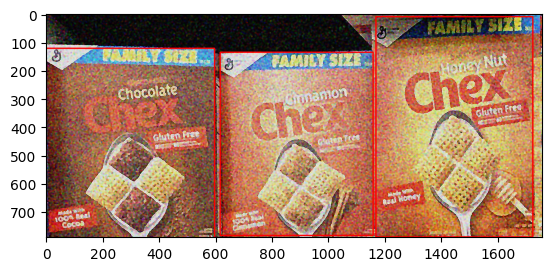

Object 6: {position: (298.1005554199219, 457.08697509765625), width: 600px, height: 670px
Object 7: {position: (888.77490234375, 460.11749267578125), width: 542px, height: 649px
Object 8: {position: (1447.249267578125, 399.4851989746094), width: 556px, height: 779px


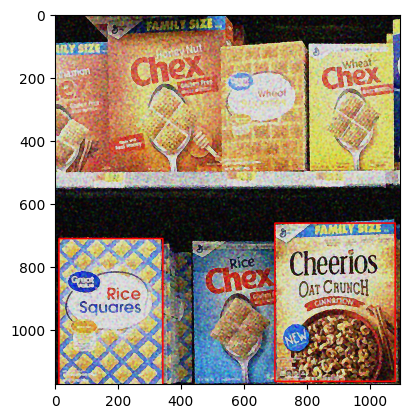

Object 1: {position: (887.012451171875, 914.4885864257812), width: 381px, height: 501px
Object 9: {position: (177.4031982421875, 947.3363647460938), width: 329px, height: 469px


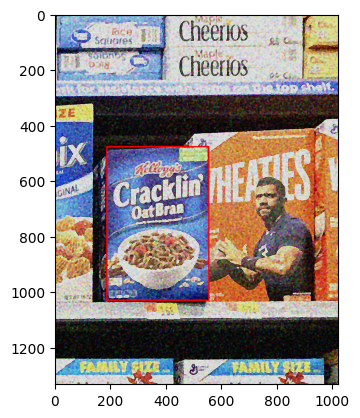

Object 11: {position: (369.88470458984375, 753.77783203125), width: 367px, height: 553px


In [18]:
contain_img = {}
# Iterate among scenes
imgs_train_filterd = ['dataset/scenes/scene{}_filtered.png'.format(i) for i in range(1, 6)]
for scene_image in imgs_train_filterd:
  # Count instances of each object
  object_counts = {}
  # Initialize variables to store accumulated bounding box information
  all_bounding_boxes = []
  all_center_positions = []
  img_train = cv2.imread(scene_image,0)
  img = cv2.imread(scene_image)

  #Iterate among queryimage to see if in scene
  for i in range(1, 15):
      img_query = cv2.imread('dataset/models/ref{}.png'.format(i),0)

      good, kp_query = object_retrieve(img_query, img_train, 70)

      if good != None:
        # Get bounding boxes, and append to variables to accumulated bounding box information
        img_train_with_box, bounding_box_height, bounding_box_width, center_position = poistion_estimation(good, kp_query, img_query, img_train)
        all_bounding_boxes.append((bounding_box_height, bounding_box_width,i))
        all_center_positions.append(center_position)

        # Count instances of each object
        object_counts.setdefault(len(all_bounding_boxes), 0)
        object_counts[len(all_bounding_boxes)] += 1
  # Draw all bounding boxes on a single image
  if img_train_with_box is not None:
      img_with_boxes = img.copy()
      for i, ((bounding_box_height, bounding_box_width, number), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
          cv2.rectangle(img_with_boxes, (int(center_position[0] - bounding_box_width / 2),
                                           int(center_position[1] - bounding_box_height / 2)),
                          (int(center_position[0] + bounding_box_width / 2),
                           int(center_position[1] + bounding_box_height / 2)), (0, 0, 255), 3)
      plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
      plt.show()

      # Print location information for each instance
      for k, ((bounding_box_height, bounding_box_width, number), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
        print(f'Product {number} instance found: {{position: {center_position}, width: {round(bounding_box_width)}px, height: {round(bounding_box_height)}px')



# For mutiple

## Filtering

As stated before, the scene images contain some noise. We therfore start by denoising the scene iamges before further processing.

As the first two scene images (6 and 7) are less noisy than the rest, we have decided to filter more for the three last images than for the two first.

In [20]:
import cv2
imgs_train = ['dataset/scenes/scene{}.png'.format(i) for i in range(6, 13)]
for i in range(len(imgs_train)):
  img = cv2.imread(imgs_train[i])
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if i < 2:
    img_rgb = cv2.bilateralFilter(img_rgb, 15, 200, 100)
  else:
    median_blur = cv2.medianBlur(img_rgb, 5)

    # Apply Gaussian Blur to smooth the image
    gaussian_blur = cv2.GaussianBlur(median_blur, (5, 5), 0)

    # Apply Bilateral Filter to preserve edges while reducing noise
    img_rgb= cv2.bilateralFilter(gaussian_blur, 9, 75, 75)

    # Convert to grayscale
    gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # Apply Laplacian filter for edge detection and sharpening
    laplacian = cv2.Laplacian(img_rgb, cv2.CV_64F)
    sharp_edges = cv2.convertScaleAbs(laplacian)

    # Combine the original color image with the sharp edges
    img_rgb = cv2.addWeighted(img_rgb, 0.8, sharp_edges, 0.2, 0)

  name = imgs_train[i].replace(".png", "_filtered.png")
  cv2.imwrite(name, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))

  print(f"save succeded as: {name}")

save succeded as: dataset/scenes/scene6_filtered.png
save succeded as: dataset/scenes/scene7_filtered.png
save succeded as: dataset/scenes/scene8_filtered.png
save succeded as: dataset/scenes/scene9_filtered.png
save succeded as: dataset/scenes/scene10_filtered.png
save succeded as: dataset/scenes/scene11_filtered.png
save succeded as: dataset/scenes/scene12_filtered.png



We iterate over all scene images and models with single instance, and call the two functions above in order to detect the objects.

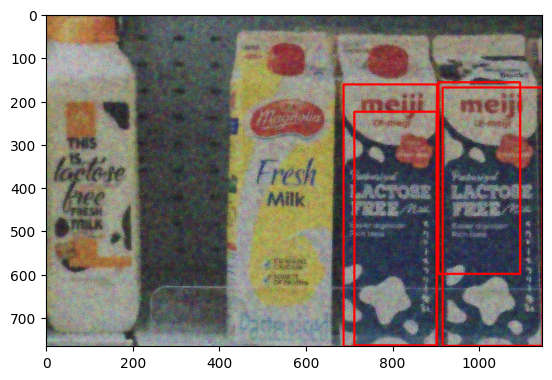

Product 16 - 4 instances found
Instance 1: {position: (795.555908203125, 464.8990478515625), width: 217px, height: 606px
Instance 2: {position: (807.6007080078125, 495.283935546875), width: 189px, height: 539px
Instance 3: {position: (1031.89013671875, 467.31842041015625), width: 230px, height: 596px
Instance 4: {position: (1000.99267578125, 378.54510498046875), width: 189px, height: 441px


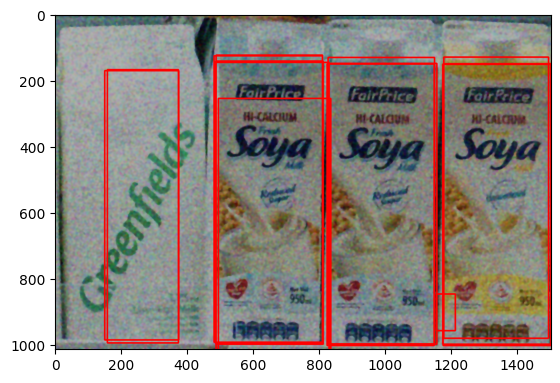

Product 17 - 4 instances found
Instance 1: {position: (649.25341796875, 571.1871948242188), width: 325px, height: 857px
Instance 2: {position: (645.7103271484375, 560.2930908203125), width: 328px, height: 867px
Instance 3: {position: (989.8223876953125, 574.5811767578125), width: 331px, height: 849px
Instance 4: {position: (1342.0146484375, 576.8154296875), width: 335px, height: 853px
Product 23 - 6 instances found
Instance 1: {position: (664.4423828125, 638.5523071289062), width: 341px, height: 766px
Instance 2: {position: (648.273193359375, 561.3961791992188), width: 321px, height: 874px
Instance 3: {position: (815.34619140625, 649.4913330078125), width: 0px, height: 1px
Instance 4: {position: (987.30029296875, 565.2203979492188), width: 322px, height: 867px
Instance 5: {position: (1183.094482421875, 903.2711181640625), width: 57px, height: 111px
Instance 6: {position: (1334.669677734375, 556.283935546875), width: 317px, height: 851px
Product 24 - 3 instances found
Instance 1: {posit

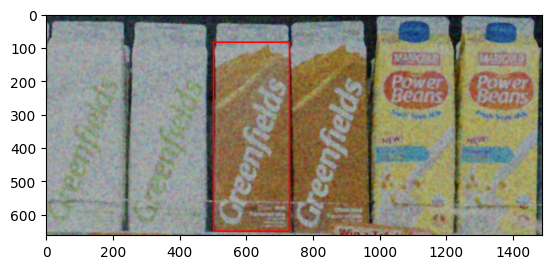

Product 19 - 1 instances found
Instance 1: {position: (616.354248046875, 367.7019348144531), width: 229px, height: 566px


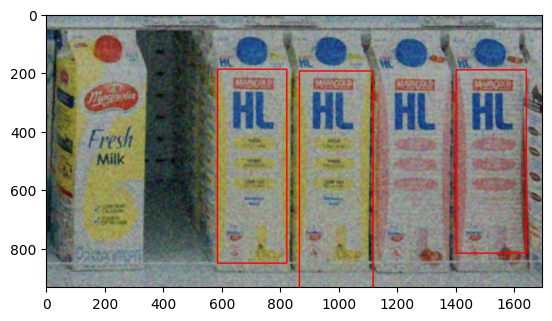

Product 21 - 3 instances found
Instance 1: {position: (704.8035888671875, 519.6001586914062), width: 237px, height: 661px
Instance 2: {position: (992.4805297851562, 571.2783203125), width: 252px, height: 754px
Instance 3: {position: (1522.39599609375, 503.5851135253906), width: 241px, height: 626px


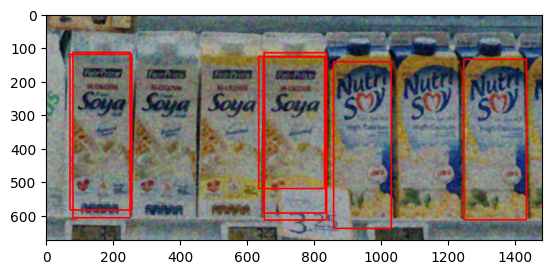

Product 17 - 2 instances found
Instance 1: {position: (163.98324584960938, 352.1576843261719), width: 186px, height: 464px
Instance 2: {position: (733.9427490234375, 323.1902770996094), width: 197px, height: 394px
Product 23 - 2 instances found
Instance 1: {position: (165.9099578857422, 360.78106689453125), width: 171px, height: 493px
Instance 2: {position: (745.5101318359375, 365.48626708984375), width: 186px, height: 499px
Product 24 - 1 instances found
Instance 1: {position: (742.44384765625, 360.84075927734375), width: 185px, height: 465px
Product 25 - 2 instances found
Instance 1: {position: (945.5321655273438, 391.450439453125), width: 171px, height: 497px
Instance 2: {position: (1341.843505859375, 374.5831298828125), width: 187px, height: 478px


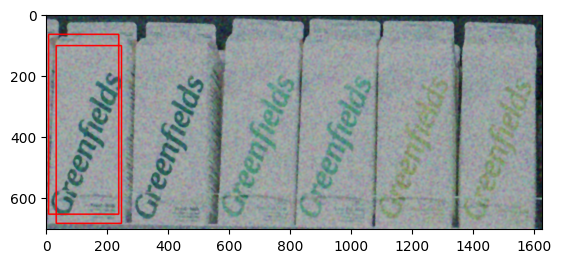

Product 18 - 1 instances found
Instance 1: {position: (123.33619689941406, 360.9903564453125), width: 230px, height: 589px
Product 26 - 1 instances found
Instance 1: {position: (140.60260009765625, 394.1426086425781), width: 214px, height: 582px


In [37]:
contain_img = {}
# Iterate among scenes
imgs_train_filterd = ['dataset/scenes/scene{}_filtered.png'.format(i) for i in range(7, 13)]
for scene_image in imgs_train_filterd:
  # Count instances of each object
  object_counts = {}
  # Initialize variables to store accumulated bounding box information
  all_bounding_boxes = []
  all_center_positions = []
  img_train = cv2.imread(scene_image,0)
  img = cv2.imread(scene_image)
  #Iterate among queryimage to see if in scene
  for i in range(15, 27):
      img_query = cv2.imread('dataset/models/ref{}.png'.format(i),0)

      found, kp_query, kp_train = object_retrieve_mult(img_query, img_train, 23)

      if found != []:
        for element in found:
          # Get bounding boxes, and append to variables to accumulated bounding box information
          img_train_with_box, bounding_box_height, bounding_box_width, center_position = poistion_estimation(element, kp_query, img_query, img_train)
          all_bounding_boxes.append((bounding_box_height, bounding_box_width,i))
          all_center_positions.append(center_position)

          img_with_boxes = img.copy()

          # Count instances of each object
          object_id = i
          if object_id in object_counts:
              object_counts[object_id] += 1
          else:
            object_counts[object_id] = 1

  # Draw all bounding boxes on a single image
  if img_train_with_box is not None:
      img_with_boxes = img.copy()

      for i, ((bounding_box_height, bounding_box_width, number), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
          cv2.rectangle(img_with_boxes, (int(center_position[0] - bounding_box_width / 2),
                                           int(center_position[1] - bounding_box_height / 2)),
                          (int(center_position[0] + bounding_box_width / 2),
                           int(center_position[1] + bounding_box_height / 2)), (0, 0, 255), 3)
      plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
      plt.show()

      # Create parameters to keep track of printing
      last_number = 0
      instance_count=0
      # Print location information for each instance
      for k, ((bounding_box_height, bounding_box_width, number), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
        if number != last_number:
          print(f'Product {number} - {object_counts[number]} instances found')
          last_number = number
          instance_count = 1
        else:
          instance_count +=1
        print(f'Instance {instance_count}: {{position: {center_position}, width: {round(bounding_box_width)}px, height: {round(bounding_box_height)}px')
